In [91]:
import pandas as pd
import numpy as np
import gzip
import os
import datetime
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import gc
import re
#import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib
import pandas_ta as ta

import warnings

import requests

import hmac
import hashlib

import aiohttp
import asyncio

import logging
from datetime import timezone

import nest_asyncio

# Filter depreciation warnings from pandas regarding the append method
warnings.filterwarnings('ignore', category=FutureWarning, message=".*append.*")
pd.options.mode.chained_assignment = None

# Set pandas to display all digits for floating-point numbers
pd.options.display.float_format = '{:.8f}'.format

import os
from dotenv import load_dotenv

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Ignore only FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

# Ignore only RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

import importlib


from Orats_options_fetch_functions import *

from faster_numba_strategy_functions import *

import strategy_functions

importlib.reload(strategy_functions)
from strategy_functions import *

# import Common_functions

# importlib.reload(strategy_functions)
# importlib.reload(Common_functions)

# from Common_functions import *
# coin_desk_api_key =  "e43c1fd991e660b9bf959645f0800bb7e76fb4a3537ab773cec62b2fad31af2d"
from datetime import time
from pathlib import Path
# Get the user's home directory dynamically
home_dir = Path.home()
#====================================

strategy_name = "Nifty_200_rng_brkout_int"

# Create a folder for the strategy_name if it doesn't exist in home directory

strategy_folder = os.path.join(home_dir, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")

#=== location to store the trade dataframe for debug

base_folder_df = "strategy_dataframe"
df_folder = os.path.join(strategy_folder, base_folder_df)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)
    print("\n Created strategy dataframe folder : " ,df_folder )

#----- symbol_wise_trades

trades_folder = "sym_wise_trades"
trades_strategy_folder = os.path.join(strategy_folder, trades_folder)

if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)

logger = setup_logger("Straddle_0DTE", strategy_folder, log_file="strategy.log" , to_console=False)


In [92]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Connect to an in-memory database
con = duckdb.connect()

# --- Your setup code (which is correct) ---
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")
con.execute("""
SET s3_endpoint='122.176.133.73:9000';
SET s3_use_ssl=false;
SET s3_access_key_id='minioadmin';
SET s3_secret_access_key='minioadmin';
""")
con.execute("SET s3_url_style='path';") 
con.execute("PRAGMA threads=8;")
con.execute("PRAGMA enable_object_cache;")

# --- THE MISSING STEP: Querying a file from S3 ---
# Replace with your actual S3 bucket and file path
# This can be a .parquet, .csv, or .json file
s3_file_path = 's3://duckdata/ORATS/Options/**/*.parquet'

try:
    # Execute a query on the S3 file and fetch the result as a Pandas DataFrame
    print(f"Querying data from: {s3_file_path}")
    df = con.execute(f"""
        SELECT *
        FROM '{s3_file_path}'
        LIMIT 2;
    """).df()

    print("\n✅ Query successful! First 5 rows of data:")
    print(df.head())

except Exception as e:
    print(f"\n❌ An error occurred during the query: {e}")

# finally:
#     # It's good practice to close the connection
#     con.close()

Querying data from: s3://duckdata/ORATS/Options/**/*.parquet

✅ Query successful! First 5 rows of data:
      expiry       strike  dte  optionType                  ts         low  \
0 2024-01-26 421.00000000   25          -1 2024-01-02 17:13:00 17.18000000   
1 2024-01-12 414.00000000   11          -1 2024-01-02 17:13:00 10.41500000   

         high        open       close     volume  ...      askSize  \
0 17.18000000 17.18000000 17.18000000 0.00000000  ...  50.00000000   
1 10.41500000 10.41500000 10.41500000 0.00000000  ... 151.00000000   

     bidPrice    askPrice      bidIv      askIv         iv          oi  \
0 17.12000000 17.24000000 0.13785700 0.14511500 0.14148600 15.00000000   
1 10.34000000 10.49000000 0.14267100 0.15199600 0.14733300 54.00000000   

    stockPrice        day ticker  
0 404.00000000 2024-01-02    QQQ  
1 404.00000000 2024-01-02    QQQ  

[2 rows x 21 columns]


In [33]:

ifol = r"C:\Data\Aggregate_Data\Us_etfs\US_IBKR\SPY_IBKR_5min_2019_2025.parquet"
#== read the RELIANCE data

com_df2 = pd.read_parquet(ifol)

com_df2.dropna(how='all', inplace=True)

vix_df = pd.read_parquet(r"C:\Data\Aggregate_Data\Us_etfs\VIX_2019_2025_15min.parquet")

vix_df.columns = vix_df.columns.str.lower()
vix_df = vix_df.add_prefix(f'VIX_')
com_df2 = pd.concat([com_df2 , vix_df] , join='outer' , axis=1)

final_symbols = com_df2.filter(like='close').columns.str.replace('_close', '')
print("Total symbols found after all filtering: ", len(final_symbols))

# Calculate the number of rows in the DataFrame

com_df2[[f"{symbol}_intraday_low" for symbol in final_symbols]] =com_df2[[f"{symbol}_low" for symbol in final_symbols]].apply(lambda x: intraday_low(com_df2, low_col=x.name,agg_func='min'))

com_df2[[f"{symbol}_intraday_high" for symbol in final_symbols]] =com_df2[[f"{symbol}_high" for symbol in final_symbols]].apply(lambda x: intraday_high(com_df2, high_col=x.name,agg_func='max'))

com_df2[[f"{symbol}_todayo" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: get_x_min_close_numba(com_df2, column=x.name, start='09:30', end='09:35'))

# com_df2[[f"{symbol}_daily_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=50)

# com_df2[[f"{symbol}_ROC" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change()

# com_df2[[f"{symbol}_ROC_4" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].pct_change(periods=4)

com_df2[[f"{symbol}_prevdayl" for symbol in final_symbols]] = com_df2[[f"{symbol}_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_prevdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_high" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=1, column=x.name))

com_df2[[f"{symbol}_secdayh" for symbol in final_symbols]] = com_df2[[f"{symbol}_high" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=2, column=x.name))


# pivot_features_df = calculate_pivots_vectorized(df=com_df2, symbols=final_symbols,freq='W-SUN', origin='start_day')
# pivot_features_df.dropna(how='all' , inplace=True)
# com_df2 = pd.concat([com_df2 , pivot_features_df] , join='outer' , axis=1)
# del pivot_features_df
# gc.collect()


# This single call does it for the 20-day MA
ma_20d_df = calculate_daily_ma_vectorized(df=com_df2, symbols=final_symbols, periods=3 , agg_func='last' , col_suffix='high')

    # Join the new features back to the main DataFrame
com_df2 = pd.concat([com_df2, ma_20d_df] , axis=1 , join='outer')

# This single call does it for the 3-day MA
ma_3d_df = calculate_daily_ma_vectorized(com_df2, final_symbols, periods=3)

#     # Join the new features back to the main DataFrame
com_df2 = pd.concat([com_df2, ma_3d_df] , axis=1 , join='outer')

com_df2[[f"{symbol}_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].rolling(2).mean()

com_df2[[f"{symbol}_ROC_100" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].pct_change(periods=100)



#com_df2[[f"{symbol}_ma_3d_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma" for symbol in final_symbols]].values / com_df2[[f"{symbol}_3d_MA" for symbol in final_symbols]].values

com_df2[[f"{symbol}_prevdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=1))

com_df2[[f"{symbol}_secdayc" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda x: calculate_prev_day_close(com_df2, close_col=x.name, n_days=2))


# #=== hourly volume
# com_df2[[f"{symbol}_vol_ma" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].rolling(4).mean()

# #==avg 3 day volume

# com_df2[[f"{symbol}_3d_vol_MA" for symbol in final_symbols]] = com_df2[[f"{symbol}_volume" for symbol in final_symbols]].apply(lambda x: daily_moving_average(com_df2, timeframe='1D', column=x.name, periods=3, agg_func='last'))

com_df2[[f"{symbol}_alltime_high" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda col: col.expanding().max())

com_df2[[f"{symbol}_alltime_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_close" for symbol in final_symbols]].apply(lambda col: col.expanding().min())

com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]] = com_df2[[f"{symbol}_low" for symbol in final_symbols]].rolling(2).mean()

com_df2[[f"{symbol}_ma2_high" for symbol in final_symbols]] = com_df2[[f"{symbol}_high" for symbol in final_symbols]].rolling(2).mean()


com_df2[[f"{symbol}_10dlow" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_10dhigh" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_high" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_low" for symbol in final_symbols]].apply(lambda x: get_x_day_low_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3dhigh" for symbol in final_symbols]] = com_df2[[f"{symbol}_ma2_high" for symbol in final_symbols]].apply(lambda x: get_x_day_high_numba(com_df2, n=3, column=x.name))

com_df2[[f"{symbol}_3d_rng" for symbol in final_symbols]] = (com_df2[[f"{symbol}_3dhigh" for symbol in final_symbols]].values /com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]].values)-1

com_df2[[f"{symbol}_close_S1_ratio" for symbol in final_symbols]] = com_df2[[f"{symbol}_intraday_low" for symbol in final_symbols]].values / com_df2[[f"{symbol}_3dlow" for symbol in final_symbols]].values


# Calculate highest high of last 4 bars
com_df2[[f"{symbol}_high_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_high" for symbol in final_symbols]].rolling(4).max()

# Calculate lowest low of last 4 bars
com_df2[[f"{symbol}_low_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_low" for symbol in final_symbols]].rolling(4).min()

# Calculate range (difference between highest high and lowest low)
com_df2[[f"{symbol}_range_4bar" for symbol in final_symbols]] = (
    com_df2[[f"{symbol}_high_4bar" for symbol in final_symbols]].values - 
    com_df2[[f"{symbol}_low_4bar" for symbol in final_symbols]].values
)

# Calculate mean range (average of the 4-bar ranges)
com_df2[[f"{symbol}_mean_range_4bar" for symbol in final_symbols]] = com_df2[[f"{symbol}_range_4bar" for symbol in final_symbols]].rolling(12).mean()

com_df2.to_parquet(r"Dataframe.parquet")


# This single function call replaces your entire for loop for the ATR
atr_features_df = calculate_atr_mtf_vectorized(
    df=com_df2,
    symbols=final_symbols,
    resample_tf='1D',
    atr_period=5 , origin_time='start'
)


# This single function call replaces your entire for loop for the ATR
atr_features_df2 = calculate_atr_mtf_vectorized(
    df=com_df2,
    symbols=final_symbols,
    resample_tf='15min',
    atr_period=2 , origin_time='start'
)

atr_features_df3 = calculate_atr_pandas_ta_vectorized(com_df2, final_symbols, atr_period=2)


com_df2 = pd.concat([com_df2 , atr_features_df] , join='outer' , axis=1)

com_df2 = pd.concat([com_df2 , atr_features_df2] , join='outer' , axis=1)
               
com_df2 = pd.concat([com_df2 , atr_features_df3] , join='outer' , axis=1)



import gc
del atr_features_df
del atr_features_df2

gc.collect()

for symbol in final_symbols:

     # Calculate NATR (Normalized ATR)
    com_df2[f"{symbol}_NATR"] = com_df2[f"{symbol}_1D_ATR"].values / com_df2[f"{symbol}_close"].values
    com_df2[f'{symbol}_iATR'] = com_df2[f"{symbol}_15MIN_ATR"].values / com_df2[f"{symbol}_close"].values
    com_df2[f'{symbol}_iATR2'] = com_df2[f"{symbol}_ATR"].values / com_df2[f"{symbol}_close"].values

#=== the concept is----

# ... (your existing for loop to calculate the ATR values)

# --- ✅ NEW CODE TO SAVE THE RESULTS ---

# 1. Create a list of all the column names you want to save
iatr_cols_to_save = []
for symbol in final_symbols:
    iatr_cols_to_save.append(f"{symbol}_iATR")
    iatr_cols_to_save.append(f"{symbol}_iATR2")

# 2. Select only those columns from your main DataFrame
atr_df_to_save = com_df2[iatr_cols_to_save]

# 3. Save the new DataFrame to a CSV file
output_filename = "atr.csv"
atr_df_to_save.to_csv(output_filename)

print(f"Successfully saved iATR and iATR2 values to {output_filename}")


roc_df = com_df2.filter(regex='^[^_]+_NATR$', axis=1).copy(deep=True)

ranked_roc_df = roc_df.rank(axis=1, method='first', ascending=False)
ranked_roc_df = ranked_roc_df.add_suffix('_Rank')

#== number of symbols per row whicha actually have a value
total_symbols_per_row  = ranked_roc_df.filter(regex='_NATR').count(axis=1)

#== Calculate top and bottom N symbols based on the total symbols per row

top_n = np.maximum(1, np.ceil(total_symbols_per_row * 0.1).astype(int))
bottom_n = np.maximum(1, total_symbols_per_row - np.ceil(total_symbols_per_row * 0.5).astype(int))

com_df2 = pd.concat([com_df2 , ranked_roc_df] , axis=1 , join='outer' , ignore_index=False)
com_df2['top_ranks'] = top_n
com_df2['bottom_ranks'] = bottom_n

#==== find the Percentile


# 1. Generate the correctly ordered lists of column names
# The `final_symbols` list already provides the correct order.
close_cols = [f"{symbol}_close" for symbol in final_symbols]
low_3d_cols = [f"{symbol}_10dlow" for symbol in final_symbols]
high_3d_cols = [f"{symbol}_10dhigh" for symbol in final_symbols]

close_values = com_df2[close_cols].values
low_3d_values = com_df2[low_3d_cols].values
high_3d_values = com_df2[high_3d_cols].values

# 3. Perform the vectorized calculation on the arrays
numerator = close_values - low_3d_values
denominator = high_3d_values - low_3d_values

# np.divide handles division by zero safely
percentile_values = np.divide(numerator, denominator, where=denominator!=0)

# 4. Create the new feature DataFrame
# Use a new list comprehension for the output column names
pctl_cols = [f"{symbol}_3d_Pctl" for symbol in final_symbols]
percentile_df = pd.DataFrame(percentile_values, index=com_df2.index, columns=pctl_cols)

# Clip values to handle floating point inaccuracies
percentile_df = percentile_df.clip(0, 1)

# 5. Join the result back to the main DataFrame
com_df2 = com_df2.join(percentile_df)


com_df2['decent'] = np.where((com_df2['SPY_todayo'] < com_df2['SPY_prevdayl'] * 1.001) & (com_df2['SPY_close'] < com_df2['SPY_prevdayc'] * 0.997), 1, 0)
com_df = com_df2[com_df2['decent']==1]
com_df = com_df[com_df.index.year>=2024]

Total symbols found after all filtering:  2
Calculating 3-day MA for 2 symbols...
Calculating 3-day MA for 2 symbols...
Vectorized MTF ATR for 2 symbols...
Vectorized MTF ATR for 2 symbols...
Successfully saved iATR and iATR2 values to atr.csv


In [65]:
import pandas as pd
import pandas_market_calendars as mcal
import duckdb

def find_missing_data_days(con, ticker, path_template, start_date_str, end_date_str):
    """
    Checks a date range against an S3 source using DuckDB and returns a list 
    of trading days with missing data files.

    Args:
        con: An initialized and configured DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        path_template (str): A formatted string for the S3 path, e.g., 
                             "s3://bucket/folder/ticker={ticker}/day={date}/*.parquet".
        start_date_str (str): The first day of the range to check ('YYYY-MM-DD').
        end_date_str (str): The last day of the range to check ('YYYY-MM-DD').

    Returns:
        list: A list of date strings ('YYYY-MM-DD') for which data is missing.
    """
    # 1. Generate a definitive list of all expected trading days
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start_date=start_date_str, end_date=end_date_str)
    expected_days = [d.strftime('%Y-%m-%d') for d in schedule.index]
    
    print(f"Checking {len(expected_days)} expected trading days between {start_date_str} and {end_date_str}...")

    missing_days = []
    # 2. Loop through each expected day and try to query it
    for day_str in expected_days:
        # Fill in the path template with the specific ticker and date
        path_to_check = path_template.format(ticker=ticker, date=day_str)
        query = f"SELECT COUNT(*) FROM read_parquet('{path_to_check}');"
        
        try:
            # Try to run the lightweight count query
            result = con.execute(query).fetchone()
            if result[0] == 0:
                # File exists but is empty
                print(f"  ⚠️ INFO: File for {day_str} exists but is empty.")
                missing_days.append(day_str)
                
        except duckdb.IOException as e:
            # This error means the file was not found
            print(f"  ❌ MISSING: No file found for {day_str}.")
            missing_days.append(day_str)
        except Exception as e:
            # Handle other potential errors
            print(f"  An error occurred checking {day_str}: {e}")
            missing_days.append(day_str)

    return missing_days

# ==============================================================================
# --- Example Usage ---
# ==============================================================================


# 2. Define the path template with placeholders for the ticker and date
path_template = "s3://duckdata/ORATS/Options/ticker={ticker}/day={date}/*.parquet"

# # 3. Define the date range you want to audit
# start_date = com_df.index[0].strftime('%Y-%m-%d')
# end_date = com_df.index[-1].strftime('%Y-%m-%d')

start_date = datetime(2024 ,1 , 1)
end_date = datetime(2024 , 12 , 31)


# 4. Call the function
# This will connect to your S3 and check each day in the range.
missing_dates = find_missing_data_days(con, 'SPY', path_template, start_date, end_date)



print("\n--- Data Audit Complete ---")
if missing_dates:
    print("The following trading days are missing data files:")
    for d in missing_dates:
        print(f" - {d}")
else:
    print("✅ All expected trading days were found.")

con.close()

Checking 252 expected trading days between 2024-01-01 00:00:00 and 2024-12-31 00:00:00...
  ❌ MISSING: No file found for 2024-07-05.
  ❌ MISSING: No file found for 2024-07-08.
  ❌ MISSING: No file found for 2024-07-09.
  ❌ MISSING: No file found for 2024-07-10.
  ❌ MISSING: No file found for 2024-11-29.
  ❌ MISSING: No file found for 2024-12-26.
  ❌ MISSING: No file found for 2024-12-27.
  ❌ MISSING: No file found for 2024-12-30.
  ❌ MISSING: No file found for 2024-12-31.

--- Data Audit Complete ---
The following trading days are missing data files:
 - 2024-07-05
 - 2024-07-08
 - 2024-07-09
 - 2024-07-10
 - 2024-11-29
 - 2024-12-26
 - 2024-12-27
 - 2024-12-30
 - 2024-12-31


In [75]:
com_df2 = com_df2[com_df2.index.year>=2024]
com_df2 = com_df2[com_df2.index.year<2025]


In [84]:
unique_date = com_df2.index.normalize().unique()

In [85]:
unique_date

DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
               '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
               '2024-01-12', '2024-01-16',
               ...
               '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-16',
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24'],
              dtype='datetime64[ns]', length=236, freq=None)

In [189]:
# --- The One-Liner Solution ---
# Create a list of 1-minute indexes for each day and flatten it
full_datetime_index = pd.DatetimeIndex([
    item for day in unique_date 
    for item in pd.date_range(f"{day.date()} 09:30", f"{day.date()} 16:00", freq='min')
])

In [194]:
tt = pd.DataFrame(index=full_datetime_index)

In [190]:
mask = ~com_df2.index.normalize().isin(pd.to_datetime(missing_dates))

In [191]:
com_df2 = com_df2[mask]

In [192]:
com_df2.index

DatetimeIndex(['2024-01-02 09:30:00', '2024-01-02 09:35:00',
               '2024-01-02 09:40:00', '2024-01-02 09:45:00',
               '2024-01-02 09:50:00', '2024-01-02 09:55:00',
               '2024-01-02 10:00:00', '2024-01-02 10:05:00',
               '2024-01-02 10:10:00', '2024-01-02 10:15:00',
               ...
               '2024-12-24 12:15:00', '2024-12-24 12:20:00',
               '2024-12-24 12:25:00', '2024-12-24 12:30:00',
               '2024-12-24 12:35:00', '2024-12-24 12:40:00',
               '2024-12-24 12:45:00', '2024-12-24 12:50:00',
               '2024-12-24 12:55:00', '2024-12-24 13:00:00'],
              dtype='datetime64[ns]', length=18572, freq=None)

In [169]:
def fetch_atm_options_for_dataframe(con, ticker, com_df, price_col='SPY_close'):
    """
    Efficiently fetches the closest ATM call and put for every row in a DataFrame.
    """
    print(f"🚀 Preparing to fetch ATM options for {len(com_df)} timestamps...")
    
    try:
        # --- DATA PREPARATION ---
        timestamps_to_query = com_df.reset_index()
        timestamps_to_query = timestamps_to_query[['index', price_col]]
        timestamps_to_query.rename(columns={'index': 'ts', price_col: 'ref_price'}, inplace=True)

        # --- THE FIX IS HERE: Add the missing timezone handling ---
        # 1. Check if the timestamp column is naive or aware
        if timestamps_to_query['ts'].dt.tz is None:
            # If naive, localize to NY first
            aware_timestamps = timestamps_to_query['ts'].dt.tz_localize('America/New_York')
        else:
            # If already aware, just use it
            aware_timestamps = timestamps_to_query['ts']
            
        # 2. Create the 'ts_utc' column needed for the fast JOIN
        timestamps_to_query['ts_utc'] = aware_timestamps.dt.tz_convert('UTC')
        
        # 3. Add other necessary columns for filtering
        timestamps_to_query['expiry_str'] = (aware_timestamps).dt.strftime('%Y-%m-%d')
        print(f"Timestamps are:{timestamps_to_query}")
        # --- Path generation (your existing code is correct) ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # (Your query follows, it will now work because 'ts_utc' exists)
        query = f"""
            WITH JoinedData AS (
                SELECT 
                    t.ts AS target_ts,
                    t.ref_price,
                    o.ts AS option_ts, -- The actual timestamp from the options file
                    o.strike,
                    o.expiry,
                    o.dte,
                    o.optionType,
                    o.bidPrice,
                    o.askPrice,
                    o.iv,
                    o.stockPrice,
                    o.ticker
                FROM timestamps_to_query AS t
                JOIN read_parquet([{paths_str}]) AS o
                  ON t.ts_utc = o.ts -- This JOIN condition will now succeed
                WHERE 
                    o.dte = 1 AND
                    o.expiry = t.expiry_str AND
                    o.optionType = 1 AND o.strike = ROUND(o.stockPrice)
            )
            SELECT *
            FROM JoinedData
            QUALIFY ROW_NUMBER() OVER (
                PARTITION BY target_ts, optionType
                
            ) = 1;
        """
        
        print("   Executing batched query...")
        atm_options = con.execute(query).df()
        
        return atm_options

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [284]:
import pandas as pd

def fetch_atm_options_for_dataframe(con, ticker, com_df):
    """
    Efficiently fetches the exact ATM call and put (where strike matches the
    rounded stock price) for every row in a DataFrame.
    """
    print(f"🚀 Preparing to fetch ATM options for {len(com_df)} timestamps...")
    
    try:
        # --- SIMPLIFIED DATA PREPARATION ---
        # 1. Reset the index to get the timestamp column
        timestamps_to_query = com_df.reset_index()
        
        # 2. Select ONLY the timestamp column. price_col is no longer needed.
        timestamps_to_query = timestamps_to_query[['index']]
        timestamps_to_query.rename(columns={'index': 'ts'}, inplace=True)

        # 3. Handle timezones and create necessary columns
        if timestamps_to_query['ts'].dt.tz is None:
            aware_timestamps = timestamps_to_query['ts'].dt.tz_localize('America/New_York')
        else:
            aware_timestamps = timestamps_to_query['ts']
        print(f"aware timtsamps are :{aware_timestamps}")    
        timestamps_to_query['ts_utc'] = aware_timestamps.dt.tz_convert('UTC')
        timestamps_to_query['expiry_str'] = (aware_timestamps).dt.strftime('%Y-%m-%d')
        
        # --- Path generation ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # --- SIMPLIFIED QUERY ---
        query = f"""
            WITH JoinedData AS (
                SELECT 
                    t.ts AS target_ts,
                    o.ts AS option_ts, -- The actual timestamp from the options file
                    o.strike,
                    o.expiry,
                    o.dte,
                    o.optionType,
                    o.bidPrice,
                    o.askPrice,
                    o.iv,
                    o.stockPrice,
                    o.ticker
                FROM timestamps_to_query AS t
                JOIN read_parquet([{paths_str}]) AS o
                  ON t.ts_utc = o.ts
                WHERE 
                    o.dte = 1 AND
                    o.expiry = t.expiry_str AND
                    
                    CAST(o.strike AS INTEGER) = CAST(ROUND(o.stockPrice) AS INTEGER) AND
                    o.optionType = 1
            )
            SELECT *
            FROM JoinedData
            QUALIFY ROW_NUMBER() OVER (
                PARTITION BY target_ts
                
            ) = 1;
        
            
        """
  
        print("   Executing simplified batched query...")
        atm_options = con.execute(query).df()
        if atm_options.empty:
            print(f"None of data is present ")
        atm_options['option_ts'] = pd.to_datetime(atm_options['option_ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        
        return atm_options

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [308]:
import pandas as pd
import duckdb

def fetch_atm_options_for_dataframe_CORRECTED(con, ticker, com_df):
    """
    Corrected version that properly handles timezones and uses a robust
    nearest-match query to find ATM options.
    """
    print(f"🚀 Preparing to fetch ATM options for {len(com_df)} timestamps...")
    
    try:
        # --- CORRECTED DATA PREPARATION ---
        timestamps_to_query = com_df.reset_index()
        timestamps_to_query.rename(columns={'index': 'ts'}, inplace=True)

        # 1. Ensure the timestamp is naive (represents wall-clock time in NY)
        if timestamps_to_query['ts'].dt.tz is not None:
            timestamps_to_query['ts'] = timestamps_to_query['ts'].dt.tz_localize(None)

        # 2. Localize to NY time, then immediately convert to UTC
        # This is a more robust way to handle the conversion.
        timestamps_to_query['ts_utc'] = timestamps_to_query['ts'].dt.tz_localize(
            'America/New_York', ambiguous='infer'
        ).dt.tz_convert('UTC')
        
        timestamps_to_query['expiry_str'] = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d')
        
        # --- Path generation ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # --- ROBUST NEAREST MATCH QUERY (The correct long-term solution) ---
        query = f"""
            WITH RankedOptions AS (
                SELECT 
                    t.ts AS target_ts,
                    o.ts AS option_ts,
                    o.strike,
                    o.stockPrice,
                    o.expiry,
                    o.dte,
                    o.optionType,
                    o.bidPrice,
                    o.askPrice,
                    o.iv,
                    
                    ROW_NUMBER() OVER (
                        PARTITION BY t.ts
                        ORDER BY abs(epoch(o.ts) - epoch(t.ts_utc)) ASC
                    ) as rn
                FROM timestamps_to_query AS t
                JOIN read_parquet([{paths_str}]) AS o
                    ON strftime(t.ts_utc, '%Y-%m-%d') = strftime(o.ts, '%Y-%m-%d')
                WHERE
                    CAST(o.strike AS INTEGER) = CAST(ROUND(o.stockPrice) AS INTEGER)
                    AND o.expiry = t.expiry_str AND o.optionType = 1
            )
            SELECT * EXCLUDE(rn)
            FROM RankedOptions
            WHERE rn = 1;
        """
 
        print("   Executing robust batched query...")
        atm_options = con.execute(query).df()
        
        if atm_options.empty:
            print(f"--> No ATM options found for the given timestamps.")
        
        
        atm_options['option_ts'] = pd.to_datetime(atm_options['option_ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        return atm_options
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [293]:
import pandas as pd
import duckdb

def run_timestamp_diagnostics(con, ticker, com_df):
    """
    This function is for DIAGNOSTIC purposes only.
    It finds records within a +/- 5 second window of a target timestamp
    to reveal the exact, sub-second differences causing a strict join to fail.
    """
    print(f"🚀 Preparing to run diagnostics for {len(com_df)} timestamps...")
    
    try:
        # --- Data Preparation ---
        timestamps_to_query = com_df.reset_index()
        timestamps_to_query.rename(columns={'index': 'ts'}, inplace=True)

        if timestamps_to_query['ts'].dt.tz is None:
            aware_timestamps = timestamps_to_query['ts'].dt.tz_localize('America/New_York')
        else:
            aware_timestamps = timestamps_to_query['ts']
            
        timestamps_to_query['ts_utc'] = aware_timestamps.dt.tz_convert('UTC')
        timestamps_to_query['expiry_str'] = aware_timestamps.dt.strftime('%Y-%m-%d')
        
        # --- Path Generation ---
        unique_days = timestamps_to_query['ts'].dt.strftime('%Y-%m-%d').unique()
        path_list = [f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'" for d in unique_days]
        paths_str = ", ".join(path_list)
        
        con.register('timestamps_to_query', timestamps_to_query)

        # --- DIAGNOSTIC QUERY ---
        # This query joins on a time window to find "near misses" and show the raw values.
        query = f"""
            SELECT 
                t.ts AS target_ts_local,
                t.ts_utc AS target_ts_utc,
                o.ts AS option_ts_utc,
                -- Calculate the exact difference in microseconds for analysis
                (epoch(o.ts) - epoch(t.ts_utc)) * 1000000 AS microsecond_diff,
                o.strike,
                o.stockPrice,
                CAST(ROUND(o.stockPrice) AS INTEGER) AS rounded_stock_price
            FROM timestamps_to_query AS t
            JOIN read_parquet([{paths_str}]) AS o
                -- Key change: Join on a TIME WINDOW, not an exact match
                ON o.ts BETWEEN t.ts_utc - INTERVAL '5 seconds' AND t.ts_utc + INTERVAL '5 seconds'
            WHERE
                -- Pre-filter for the specific ATM condition you expect to be true
                CAST(o.strike AS INTEGER) = CAST(ROUND(o.stockPrice) AS INTEGER)
                AND o.expiry = t.expiry_str;
        """
 
        print("   Executing diagnostic query...")
        diagnostic_results = con.execute(query).df()
        
        if diagnostic_results.empty:
            print(f"--> DIAGNOSTIC: No records found even within a +/- 5 second window that match the ATM condition.")
        
        return diagnostic_results

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()


# --- [Step 2: Create a small, focused test case] ---
# Use the single timestamp that you believe has a perfect match.
single_timestamp_df = pd.DataFrame(
    index=pd.to_datetime(['2024-09-17 09:48:00'])
)

# --- [Step 3: Call the diagnostic function and print the results] ---
print("--- Running Timestamp Diagnostic ---")
diagnostic_df = run_timestamp_diagnostics(
    con=con, 
    ticker='SPY', 
    com_df=single_timestamp_df
)

print("\n--- Diagnostic Results ---")
print("This table shows the closest available timestamps from the data file.")
print("Look at the 'microsecond_diff' column. If it's not exactly 0, the strict join fails.")
print(diagnostic_df)

--- Running Timestamp Diagnostic ---
🚀 Preparing to run diagnostics for 1 timestamps...
   Executing diagnostic query...

--- Diagnostic Results ---
This table shows the closest available timestamps from the data file.
Look at the 'microsecond_diff' column. If it's not exactly 0, the strict join fails.
      target_ts_local             target_ts_utc       option_ts_utc  \
0 2024-09-17 09:48:00 2024-09-17 19:18:00+05:30 2024-09-17 19:18:00   
1 2024-09-17 09:48:00 2024-09-17 19:18:00+05:30 2024-09-17 19:18:00   

      microsecond_diff       strike   stockPrice  rounded_stock_price  
0 19800000000.00000000 562.00000000 562.29000000                  562  
1 19800000000.00000000 562.00000000 562.29000000                  562  


In [311]:


# 2. Call the function with your list
# The function will run ONE query to get the data for all three timestamps.
atm_options_df = fetch_atm_options_for_dataframe_CORRECTED(con, 'SPY',  tt )


🚀 Preparing to fetch ATM options for 92276 timestamps...
   Executing robust batched query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [318]:
atm_options_df = atm_options_df.sort_values(by = 'target_ts')

In [323]:
spy = atm_options_df[['option_ts' , 'stockPrice']]

In [326]:
spy.set_index('option_ts' , inplace=True)

In [329]:
spy.columns

Index(['stockPrice'], dtype='object')

In [331]:
spy = spy.rename(columns={"stockPrice":"SPY_close"})

In [333]:
spy.to_parquet(r"C:\Data\Aggregate_Data\Options\USA\SPY_1min_2024_2025_ORATS_close.parquet")

In [337]:
spy

,SPY_close
option_ts,
2024-01-02 09:30:00,472.15000000
2024-01-02 09:31:00,472.44000000
2024-01-02 09:32:00,472.63000000
2024-01-02 09:33:00,472.78000000
2024-01-02 09:34:00,472.68000000
...,...
2024-12-24 13:15:00,601.15000000
2024-12-24 13:15:00,601.15000000
2024-12-24 13:15:00,601.15000000


In [338]:
# Resample to 5-minute bars, starting the windows at 09:30
ohlc_5m = spy.resample('5T', origin='09:30:00').agg({
    'SPY_close': 'ohlc'
})

In [343]:
ohlc_5m_flat = ohlc_5m.copy()

# The column names are currently tuples, e.g., ('SPY_close', 'open')
# We join them with an underscore to create a single name, e.g., 'SPY_close_open'
ohlc_5m_flat.columns = ['_'.join(col).strip() for col in ohlc_5m_flat.columns.values]

# If you want to rename 'SPY_close_open' to 'SPY_open', you can use .rename()
ohlc_5m_flat = ohlc_5m_flat.rename(columns={
    'SPY_close_open': 'SPY_open',
    'SPY_close_high': 'SPY_high',
    'SPY_close_low': 'SPY_low',
    'SPY_close_close': 'SPY_close'
})

In [345]:
ohlc_5m_flat.to_parquet(r"C:\Data\Aggregate_Data\Options\USA\SPY_5min_2024_2025_ORATS_OHLC.parquet")

In [335]:
spydf = resample_data_crypto_fast_numba_origin(spy , timeframe='5min' , highcol='SPY_close' , lowcol='SPY_close' , opencol='SPY_close', closecol='SPY_close' , origin='9:30')

In [ ]:
spy.resample()

,Open,High,Low,Close,Volume
1970-01-20 17:20:00,472.15000000,473.57000000,468.78000000,470.37000000,0.00000000
1970-01-20 17:25:00,468.30000000,470.93000000,466.74000000,467.50000000,0.00000000
1970-01-20 17:30:00,468.43000000,475.68000000,468.43000000,475.37000000,0.00000000
1970-01-20 17:35:00,477.93000000,478.50000000,472.37000000,476.72000000,0.00000000
1970-01-20 17:40:00,475.25000000,476.55000000,470.52000000,470.73000000,0.00000000
...,...,...,...,...,...
1970-01-21 01:35:00,607.68000000,608.39000000,604.14000000,606.84000000,0.00000000
1970-01-21 01:40:00,606.89000000,607.12000000,602.87000000,604.01000000,0.00000000
1970-01-21 01:45:00,606.08000000,607.70000000,603.22000000,605.35000000,0.00000000
1970-01-21 01:50:00,591.44000000,595.58000000,581.16000000,592.46000000,0.00000000


In [ ]:

def fetch_single_option_at_timestamp(con, ticker, timestamp, strike, expiry_str, option_type ):
    
    """
    Fetches data for a single, specific option contract at a single timestamp.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        timestamp (pd.Timestamp): The specific timestamp to query (timezone-naive, e.g., EST).
        strike (float): The specific strike price.
        expiry_str (str): The expiry date, in 'YYYY-MM-DD' format.
        option_type (int): The option type (1 for Calls, 0 for Puts).

    Returns:
        pd.DataFrame: A DataFrame with a single row of data, or an empty DataFrame.
    """
    
    try:
        # --- SOLUTION: This block correctly prepares the timestamp ---
        # 1. Check if the input timestamp is naive (has no timezone info)
        if timestamp.tzinfo is None or timestamp.tzinfo.utcoffset(timestamp) is None:
            # If it's naive, localize it to New York time
            aware_timestamp = timestamp.tz_localize('America/New_York')
        else:
            # If it's already aware, just use it
            aware_timestamp = timestamp
        
        # 2. Now that we're sure it's aware, we can safely convert to UTC for the query
        # The redundant .tz_localize() call has been removed.
        utc_timestamp_str = aware_timestamp.tz_convert('UTC').strftime('%Y-%m-%d %H:%M:%S')
        date_str = aware_timestamp.strftime('%Y-%m-%d')
        print(f"Passing date to single option as {date_str} and expiry as {expiry_str}")
        query = f"""
            SELECT 
                ts, strike, expiry, dte, optionType, volume, oi,
                bidPrice, askPrice, bidIv, askIv, iv, stockPrice, ticker
            FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
            WHERE 
                ts = '{utc_timestamp_str}' AND
                strike = {strike} AND
                expiry = '{expiry_str}' AND
                optionType = {option_type};
        """
        
        option_data = con.execute(query).df()
        if option_data.empty:
            print(f"For timestamp {timestamp} coulnt fetch strike {strike} and expiry {expiry_str}")
        option_data['ts'] = pd.to_datetime(option_data['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        return option_data

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [282]:

# --- [Step 3: Define the parameters for the function call] ---
ticker_symbol = 'SPY'
target_timestamp = pd.Timestamp('2024-09-17 09:48:00')
strike_price = 562
expiration_date = '2024-09-17'
option_contract_type = 1 # 1 for Call

# --- [Step 4: Call the function and print the result] ---
print("Attempting to fetch a single option contract...")
result_df = fetch_single_option_at_timestamp(
    con=con, 
    ticker=ticker_symbol, 
    timestamp=target_timestamp, 
    strike=strike_price, 
    expiry_str=expiration_date, 
    option_type=option_contract_type
)


Attempting to fetch a single option contract...
Passing date to single option as 2024-09-17 and expiry as 2024-09-17


In [283]:
result_df

,ts,strike,expiry,dte,optionType,volume,oi,bidPrice,askPrice,bidIv,askIv,iv,stockPrice,ticker
0,2024-09-17 09:48:00,562.00000000,2024-09-17,1,1,60.00000000,7979.00000000,3.70000000,3.75000000,0.24967100,0.25995000,0.25481000,565.29000000,SPY


In [106]:
import pandas as pd

def fetch_specific_straddle(con, ticker, timestamp, expiry_str, call_strike, put_strike):
    """
    Fetches data for a specific call and put leg at a single timestamp.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        timestamp (pd.Timestamp): The specific timestamp to query (timezone-aware or naive).
        expiry_str (str): The expiry date for the options, in 'YYYY-MM-DD' format.
        call_strike (float): The exact strike price of the call option.
        put_strike (float): The exact strike price of the put option.

    Returns:
        pd.DataFrame: A DataFrame with data for the found options (up to 2 rows),
                      or an empty DataFrame if not found.
    """
    # 1. Ensure the timestamp is properly localized to NY and converted to UTC for the query
    if timestamp.tzinfo is None:
        timestamp = timestamp.tz_localize('America/New_York')
    
    date_str = timestamp.strftime('%Y-%m-%d')
    utc_timestamp_str = timestamp.tz_convert('UTC').strftime('%Y-%m-%d %H:%M:%S')

    print(f"Fetching {ticker} legs for expiry {expiry_str} at {utc_timestamp_str}: Call @ {call_strike}, Put @ {put_strike}")

    try:
        # The query is simplified to find the two exact strikes.
        query = f"""
            SELECT 
                ts, strike, expiry, dte, optionType, volume, oi,
                bidPrice, askPrice, bidIv, askIv, iv, stockPrice, ticker
            FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
            WHERE
                ts = '{utc_timestamp_str}' AND
                expiry = '{expiry_str}' AND
                (
                    (optionType = 1 AND strike = {call_strike}) OR
                    (optionType = -1 AND strike = {put_strike})
                );
        """
        
        straddle_df = con.execute(query).df()
        
        if straddle_df.empty:
            print("INFO: Could not find one or both of the specified option legs.")
        
        # Convert timestamp back to a user-friendly format
        if not straddle_df.empty:
            straddle_df['ts'] = pd.to_datetime(straddle_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))


        return straddle_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [107]:

def find_straddle_at_timestamp(con, ticker, timestamp, expiry_str, underlying_price, percentage_away):
    """
    Finds the closest matching call and put for a straddle at a single timestamp.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        timestamp (pd.Timestamp): The specific timestamp to query (e.g., in EST).
        expiry_str (str): The expiry date for the options, in 'YYYY-MM-DD' format.
        underlying_price (float): The reference stock price to calculate strikes from.
        percentage_away (float): The percentage to calculate strike distance.

    Returns:
        pd.DataFrame: A DataFrame with the data for the two selected options,
                      or an empty DataFrame if not found.
    """
    # date_str = timestamp.strftime('%Y-%m-%d')
    # utc_timestamp_str = timestamp.tz_localize('America/New_York').tz_convert('UTC').strftime('%Y-%m-%d %H:%M:%S')
    
    # 1. Check if the input timestamp is naive (has no timezone info)

   

    if timestamp.tzinfo is None or timestamp.tzinfo.utcoffset(timestamp) is None:
        # If it's naive, localize it to New York time
        timestamp = timestamp.tz_localize('America/New_York')
    
    # 2. Now that we're sure it's timezone-aware, we can safely convert to UTC for the query
    date_str = timestamp.strftime('%Y-%m-%d')
    utc_timestamp_str = timestamp.tz_convert('UTC').strftime('%Y-%m-%d %H:%M:%S')
    

    print(f"Finding straddle for {ticker} and expiry{expiry_str} at {timestamp} but for DB its {utc_timestamp_str} with {percentage_away:.2%} offset...")

    try:
        # Calculate target strikes directly in Python
        target_call_strike = (underlying_price * (1 + percentage_away))+1
        target_put_strike = (underlying_price * (1 - percentage_away))
        print(f"Call fetch is {target_call_strike} and put is {target_put_strike}")
        print(f"Expiries fetched are {expiry_str}")
        # The query is now faster with the added 'ts' filter
        query = f"""
            SELECT 
                ts, strike, expiry, dte, optionType, volume, oi,
                bidPrice, askPrice, bidIv, askIv, iv, stockPrice, ticker
            FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
            WHERE
                ts = '{utc_timestamp_str}' AND -- <-- KEY CHANGE: Filter for the exact timestamp
                expiry = '{expiry_str}' AND dte=1
            QUALIFY
                ROW_NUMBER() OVER (
                    PARTITION BY optionType 
                    ORDER BY 
                        ABS(strike - CASE 
                                        WHEN optionType = 1 THEN {target_call_strike}
                                        ELSE {target_put_strike}
                                     END)
                ) = 1;
        """
        
        straddle_df = con.execute(query).df()
        
        if straddle_df.empty:
            print("INFO: Could not find matching straddle options at this timestamp.")
        
        straddle_df['ts'] = pd.to_datetime(straddle_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))

        return straddle_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()



In [4]:
date_str = '2024-01-02'
ticker = "SPY"
query = f"""
            SELECT 
                ts, strike, expiry, dte, optionType, volume, oi,
                bidPrice, askPrice, bidIv, askIv, iv, stockPrice, ticker
            FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
            
        """
        
straddle_df = con.execute(query).df()

if straddle_df.empty:
    print("INFO: Could not find matching straddle options at this timestamp.")

straddle_df['ts'] = pd.to_datetime(straddle_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
straddle_df['dte'].unique()

array([   4,  746,  172,    8,   18,   25,  382,   30,  179,  120,  536,
         74,  365,  109,   46,   59,    2,  273,  263,  151,  718,    7,
       1082,   32,    9,   87,   10,    3,    1,  445,   11,   39,   15,
        354], dtype=int64)

In [8]:
straddle_df[straddle_df['dte']==1]

,ts,strike,expiry,dte,optionType,volume,oi,bidPrice,askPrice,bidIv,askIv,iv,stockPrice,ticker
62,2024-01-02 10:58:00,439.00000000,2024-01-02,1,-1,0.00000000,133.00000000,0.00000000,0.01000000,0.00000000,1.08117900,1.08117900,471.60000000,SPY
68,2024-01-02 10:58:00,404.00000000,2024-01-02,1,1,0.00000000,1.00000000,67.53000000,67.72000000,0.00000000,2.88512200,2.88512200,471.60000000,SPY
81,2024-01-02 10:58:00,490.00000000,2024-01-02,1,-1,0.00000000,0.00000000,17.99000000,18.60000000,0.00000000,1.10094300,1.10094300,471.60000000,SPY
100,2024-01-02 10:58:00,420.00000000,2024-01-02,1,1,0.00000000,128.00000000,51.36000000,51.98000000,0.00000000,2.63964000,2.63964000,471.60000000,SPY
109,2024-01-02 10:58:00,455.00000000,2024-01-02,1,-1,0.00000000,2607.00000000,0.00000000,0.01000000,0.00000000,0.58049000,0.58049000,471.60000000,SPY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108045,2024-01-02 12:26:00,474.00000000,2024-01-02,1,1,352.00000000,17073.00000000,0.24000000,0.25000000,0.16086000,0.16386000,0.16236000,472.99000000,SPY
3108070,2024-01-02 12:26:00,451.00000000,2024-01-02,1,1,0.00000000,2.00000000,21.64000000,22.30000000,0.00000000,1.49194000,1.49194000,472.99000000,SPY
3108157,2024-01-02 12:26:00,448.00000000,2024-01-02,1,-1,0.00000000,614.00000000,0.00000000,0.01000000,0.00000000,0.98645400,0.98645400,472.99000000,SPY
3108175,2024-01-02 12:26:00,540.00000000,2024-01-02,1,1,0.00000000,100.00000000,0.00000000,0.01000000,0.00000000,2.17458800,2.17458800,472.99000000,SPY


In [ ]:

# Place the SQL query inside a Python f-string
query = f"""
    SELECT 
        ts, strike, expiry, dte, optionType,
        bidPrice, askPrice, stockPrice
    FROM options_table -- Using our mock table
    WHERE
        dte = 1 AND -- Filter by dte=0 FIRST for performance
        expiry = '{expiry_str}' AND
        ts = '{utc_timestamp_str}'
    QUALIFY
        ROW_NUMBER() OVER (
            PARTITION BY optionType 
            ORDER BY 
                ABS(strike - CASE 
                    WHEN optionType = 1 THEN {target_call_strike}
                    ELSE {target_put_strike}
                END)
        ) = 1;
"""

print("--- Executing Optimized Query ---")
straddle_df = con.execute(query).df()

# ==============================================================================
# 3. PROCESS THE RESULTS
# ==============================================================================

if straddle_df.empty:
    print("\nINFO: Could not find matching straddle options at this timestamp.")
else:
    # Convert the UTC timestamp back to the local timezone for display
    straddle_df['ts'] = pd.to_datetime(straddle_df['ts']).dt.tz_convert('America/New_York')
    print("\n--- Found Straddle Legs ---")
    print(straddle_df)


In [ ]:
from datetime import time

straddle_data_log = []
daily_trade = {} # Dictionary to hold the state of the current day's trade
current_day = None # Variable to track the day

for date, row in com_df.iterrows():
    # --- Check if it's a new day to reset the trade state ---
    if date.date() != current_day:
        current_day = date.date()
        daily_trade = {} # Reset for the new day

    try:
        # --- ENTRY LOGIC: Enter at 09:35 if no position is open for the day ---
        if date.time() == time(9, 45) and not daily_trade:
            print(f"\n--- Processing Entry for: {current_day} ---")
            
            open_price = row['SPY_todayo']

            atm_strike = np.round(open_price)

            # 2. Calculate the call strike 0.3% away from the ATM strike
            call_strike = np.ceil(atm_strike * (1 + 0.003))

            # 3. Calculate the put strike 0.3% away from the ATM strike
            put_strike = np.round(atm_strike * (1 - 0.003))-1
            print(f"Strikes found for today are atm :{atm_strike} -- put is {put_strike} and call is {call_strike}")

            if pd.isna(open_price):
                print(f"  No open price for {current_day}. Skipping.")
                continue


            entry_straddle_df = fetch_specific_straddle(
                con=con,
                ticker='SPY',
                timestamp=date,
                expiry_str=date.strftime('%Y-%m-%d'),
                call_strike=call_strike,
                put_strike=put_strike
            )
            
            # --- CORRECTED LOGIC TO FIND CALL AND PUT ---
            # Check if the DataFrame contains at least one call (1) and one put (-1)
            if 1 in entry_straddle_df['optionType'].values and -1 in entry_straddle_df['optionType'].values:
                # Select the first call and first put found
                entry_call = entry_straddle_df[entry_straddle_df['optionType'] == 1].iloc[0]
                entry_put = entry_straddle_df[entry_straddle_df['optionType'] == -1].iloc[0]
                
                # Store the entry details in our state dictionary
                daily_trade = {
                    'entry_date': date,
                    'strike': entry_call['strike'],
                    'entry_call_price': entry_call['askPrice'],
                    'entry_put_price': entry_put['askPrice']
                }
                print(f"  ✅ ENTERED Straddle | Strike: {daily_trade['strike']} | Call: ${daily_trade['entry_call_price']:.2f}, Put: ${daily_trade['entry_put_price']:.2f}")
            else:
                print(f"  ⚠️ Could not find a valid call/put pair.")
        
        # ===================================================================
        elif date.time() >= time(15, 45) and daily_trade and 'exit_date' not in daily_trade:
            
            print(f"Checking exit at {date}")
            # 1. Call the function once for the Call option
            #    Note: The docstring specifies option_type=1 for Calls

            print(f"Searchi exit for {date} , {daily_trade['strike']}  , {pd.to_datetime(date).strftime('%Y-%m-%d')}")
            exit_call_df = fetch_single_option_at_timestamp(
                con=con,
                ticker='SPY',
                timestamp=date,
                strike=call_strike,
                expiry_str=pd.to_datetime(date).strftime('%Y-%m-%d'),
                option_type=1   )
            print(f"Exit callis {exit_call_df}")
            # 2. Call the function again for the Put option
            #    Note: The docstring specifies option_type=0 for Puts
            exit_put_df = fetch_single_option_at_timestamp(
                con=con,
                ticker='SPY',
                timestamp=date,
                strike=put_strike,
                expiry_str=pd.to_datetime(date).strftime('%Y-%m-%d'),
                option_type=-1    )
            print(f"Put is {exit_put_df}")

            # 3. Check if both the call and put were found successfully
            if not exit_call_df.empty and not exit_put_df.empty:
                exit_call_price = exit_call_df['bidPrice'].iloc[0]
                exit_put_price = exit_put_df['bidPrice'].iloc[0]
            
                # Update the trade dictionary with exit details
                daily_trade['exit_date'] = date
                daily_trade['exit_call_price'] = exit_call_price
                daily_trade['exit_put_price'] = exit_put_price
                
                # The exit price of the straddle is the sum of the individual leg prices
                daily_trade['straddle_exit_price'] = exit_call_price + exit_put_price

                # 4. Calculate P&L based on individual legs
                call_pnl = daily_trade['entry_call_price'] - exit_call_price 
                put_pnl =  daily_trade['entry_put_price']  - exit_put_price 
                daily_trade['pnl'] = (call_pnl + put_pnl) * 100 # Assuming multiplier of 100
                
                print(f"  ✅ EXITED Straddle | Strike: {daily_trade['strike']} | Exit Prices Call: ${exit_call_price:.2f}, Put: ${exit_put_price:.2f} | P&L: ${daily_trade['pnl']:.2f}")
                
                # Log the completed trade and reset for the day
                straddle_data_log.append(daily_trade)
                daily_trade = {} # Reset to prevent re-exiting
            else:
                print(f"  ⚠️ Could not find exit prices for one or both legs of the straddle.")
            
    except Exception as e:
        print(f"  An error occurred on {date.strftime('%Y-%m-%d')}: {e}")
    
# After the loop, you can analyze the results
if straddle_data_log:
    log_df = pd.DataFrame(straddle_data_log)
    print("\n--- Backtest Complete ---")
    print(log_df)

In [27]:
com_df

,SPY_open,SPY_high,SPY_low,SPY_close,SPY_volume,VIX_open,VIX_high,VIX_low,VIX_close,VIX_volume,...,VIX_NATR,VIX_iATR,VIX_iATR2,SPY_NATR_Rank,VIX_NATR_Rank,top_ranks,bottom_ranks,SPY_3d_Pctl,VIX_3d_Pctl,decent
2024-01-02 09:30:00,472.18000000,472.80000000,472.05000000,472.67000000,0.00000000,13.91000000,14.02000000,13.73000000,14.01000000,0.00000000,...,0.05070512,0.00785816,0.06031738,2.00000000,1.00000000,1,1,0.00000000,1.00000000,1
2024-01-02 09:35:00,472.67000000,472.74000000,471.87000000,471.92000000,0.00000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000000,NaN,1,1,0.00000000,NaN,1
2024-01-02 09:40:00,471.92000000,472.11000000,471.69000000,471.81000000,0.00000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000000,NaN,1,1,0.00000000,NaN,1
2024-01-02 09:45:00,471.81000000,472.09000000,471.39000000,471.40000000,0.00000000,13.99000000,14.09000000,13.92000000,13.92000000,0.00000000,...,0.05103296,0.06070736,0.03646000,2.00000000,1.00000000,1,1,0.00000000,1.00000000,1
2024-01-02 09:50:00,471.40000000,471.96000000,471.36000000,471.43000000,0.00000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000000,NaN,1,1,0.00000000,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23 10:55:00,577.33000000,577.58000000,577.00000000,577.13000000,0.00000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000000,NaN,1,1,0.00000000,NaN,1
2025-05-23 11:00:00,577.13000000,578.05000000,577.02000000,577.62000000,0.00000000,22.55000000,22.56000000,22.26000000,22.49000000,0.00000000,...,0.08299641,0.02604584,0.01969255,2.00000000,1.00000000,1,1,0.00000000,1.00000000,1
2025-05-23 11:05:00,577.62000000,577.70000000,576.81000000,577.57000000,0.00000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000000,NaN,1,1,0.00000000,NaN,1
2025-05-23 11:10:00,577.57000000,577.82000000,576.94000000,577.44000000,0.00000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.00000000,NaN,1,1,0.00000000,NaN,1


In [44]:
daily_event_groups = com_df.groupby(com_df.index.date)
for day, daily_events_df in daily_event_groups:
    
    # --- 3. Select only the FIRST event of the day ---
    first_event_timestamp = daily_events_df.index[0]
    first_event_row = daily_events_df.iloc[0]

    print(f"Firs event timestamp is {first_event_timestamp}")

Firs event timestamp is 2024-01-02 14:55:00
Firs event timestamp is 2024-01-03 10:35:00
Firs event timestamp is 2024-01-16 14:05:00
Firs event timestamp is 2024-01-17 13:20:00
Firs event timestamp is 2024-02-01 10:55:00
Firs event timestamp is 2024-02-05 10:10:00
Firs event timestamp is 2024-02-13 10:00:00
Firs event timestamp is 2024-02-16 09:50:00
Firs event timestamp is 2024-02-20 10:10:00
Firs event timestamp is 2024-02-21 14:30:00
Firs event timestamp is 2024-03-05 10:15:00
Firs event timestamp is 2024-03-11 09:55:00
Firs event timestamp is 2024-03-15 12:10:00
Firs event timestamp is 2024-04-10 13:05:00
Firs event timestamp is 2024-04-12 10:05:00
Firs event timestamp is 2024-05-01 10:00:00
Firs event timestamp is 2024-05-30 11:00:00
Firs event timestamp is 2024-06-04 11:55:00
Firs event timestamp is 2024-06-11 09:45:00
Firs event timestamp is 2024-07-17 10:05:00
Firs event timestamp is 2024-07-24 09:55:00
Firs event timestamp is 2024-08-02 09:50:00
Firs event timestamp is 2024-08-

In [108]:
import pandas as pd
import numpy as np

# (Assume your functions 'fetch_specific_straddle' and 'fetch_single_option_at_timestamp' are defined)

# This list will store the results of each completed trade
trade_log = []

# --- 1. Group the event DataFrame by date ---
# This is the key change to ensure we only process one event per day.
daily_event_groups = com_df.groupby(com_df.index.date)

print(f"🚀 Starting backtest for {len(daily_event_groups)} unique event days...")

# --- 2. Loop through each DAY's group of events ---
for day, daily_events_df in daily_event_groups:
    
    # --- 3. Select only the FIRST event of the day ---
    first_event_timestamp = daily_events_df.index[0]
    first_event_row = daily_events_df.iloc[0]
    
    current_day_str = first_event_timestamp.strftime('%Y-%m-%d')
    print(f"\n--- Processing Event for: {current_day_str} --- and timestamp {first_event_timestamp}" )

    try:
        # --- 4. Determine Entry Parameters from the FIRST Event ---
        
        if first_event_timestamp.time()<time(13 , 45):

            print(f"Event time is  {first_event_timestamp.time()}")
            open_price = first_event_row['SPY_open']
            if pd.isna(open_price):
                print(f"  No open price for {current_day_str}. Skipping.")
                continue
                
            atm_strike = np.round(open_price)
            call_strike = np.ceil(atm_strike * (1 + 0.005))
            put_strike = np.floor(atm_strike * (1 - 0.002)) 
            print(f"  First signal at {first_event_timestamp.time()}. ATM is {open_price} Strikes: Call @ {call_strike}, Put @ {put_strike}")

            # --- 5. Fetch Entry Prices at the time of the first event ---
            entry_legs_df = fetch_specific_straddle(
                con=con,
                ticker='SPY',
                timestamp=first_event_timestamp, # Use the first event's timestamp
                expiry_str=current_day_str,
                call_strike=call_strike,
                put_strike=put_strike
            )

            if not (1 in entry_legs_df['optionType'].values and -1 in entry_legs_df['optionType'].values):
                print(f"  ⚠️ Could not find a valid call/put pair for entry. Skipping.")
                continue
            
            entry_call = entry_legs_df[entry_legs_df['optionType'] == 1].iloc[0]
            entry_put = entry_legs_df[entry_legs_df['optionType'] == -1].iloc[0]
            entry_call_price = entry_call['askPrice']
            entry_put_price = entry_put['askPrice']
            print(f"  ✅ ENTRY at {first_event_timestamp.time()} | Call Price: ${entry_call_price:.2f}, Put Price: ${entry_put_price:.2f}")

            # --- 6. Determine Exit Time and Fetch Exit Prices ---
            exit_timestamp = first_event_timestamp.normalize().replace(hour=14, minute=45)
            
            exit_call_df = fetch_single_option_at_timestamp(
                con=con, ticker='SPY', timestamp=exit_timestamp,
                strike=call_strike, expiry_str=pd.to_datetime(current_day_str).strftime('%Y-%m-%d'), option_type=1 
            )
            exit_put_df = fetch_single_option_at_timestamp(
                con=con, ticker='SPY', timestamp=exit_timestamp,
                strike=put_strike, expiry_str=pd.to_datetime(current_day_str).strftime('%Y-%m-%d'), option_type=-1
            )

            # --- 7. Calculate P&L and Log the Trade ---
            if exit_call_df.empty or exit_put_df.empty:
                print(f"  ⚠️ Could not find exit prices for one or both legs. Skipping trade.")
                continue
                
            exit_call_price = exit_call_df['bidPrice'].iloc[0]
            exit_put_price = exit_put_df['bidPrice'].iloc[0]
            print(f"  ✅ EXIT at {exit_timestamp.time()} | Call Price: ${exit_call_price:.2f}, Put Price: ${exit_put_price:.2f}")

            call_pnl = entry_call_price - exit_call_price 
            put_pnl = exit_put_price - entry_put_price 
            total_pnl = (call_pnl + put_pnl) * 100
            
            trade_log.append({
                'entry_date': first_event_timestamp,
                'exit_date': exit_timestamp,
                'call_strike': call_strike,
                'put_strike': put_strike,
                'entry_call_price': entry_call_price,
                'entry_put_price': entry_put_price,
                'exit_call_price': exit_call_price,
                'exit_put_price': exit_put_price,
                'pnl': total_pnl
            })
            print(f"  ➡️  Trade Logged | P&L: ${total_pnl:.2f}")

    except Exception as e:
        print(f"  ❌ An error occurred processing event on {current_day_str}: {e}")
    
# --- 8. Analyze the Results ---
if trade_log:
    log_df = pd.DataFrame(trade_log)
    print("\n--- Backtest Complete ---")
    print(log_df)
else:
    print("\n--- Backtest Complete ---")
    print("No trades were executed.")




🚀 Starting backtest for 62 unique event days...

--- Processing Event for: 2024-01-02 --- and timestamp 2024-01-02 09:30:00
Event time is  09:30:00
  First signal at 09:30:00. ATM is 472.18 Strikes: Call @ 475.0, Put @ 471.0
Fetching SPY legs for expiry 2024-01-02 at 2024-01-02 14:30:00: Call @ 475.0, Put @ 471.0
  ✅ ENTRY at 09:30:00 | Call Price: $1.15, Put Price: $0.13
Passing date to single option as 2024-01-02 and expiry as 2024-01-02
Passing date to single option as 2024-01-02 and expiry as 2024-01-02
  ✅ EXIT at 14:45:00 | Call Price: $0.01, Put Price: $0.21
  ➡️  Trade Logged | P&L: $122.00

--- Processing Event for: 2024-01-03 --- and timestamp 2024-01-03 09:30:00
Event time is  09:30:00
  First signal at 09:30:00. ATM is 470.44 Strikes: Call @ 473.0, Put @ 469.0
Fetching SPY legs for expiry 2024-01-03 at 2024-01-03 14:30:00: Call @ 473.0, Put @ 469.0
  ✅ ENTRY at 09:30:00 | Call Price: $0.96, Put Price: $0.15
Passing date to single option as 2024-01-03 and expiry as 2024-01-0

In [ ]:
exit_call_df = fetch_single_option_at_timestamp(
            con=con,
            ticker='SPY',
            timestamp=date1,
            strike=473,
            expiry_str=date1.strftime('%Y-%m-%d'),
            option_type=-1 
        )

In [ ]:
straddle_df = pd.DataFrame(straddle_data_log)

In [109]:
trade_df = pd.DataFrame(trade_log)

In [95]:
trade_df

,entry_date,exit_date,call_strike,put_strike,entry_call_price,entry_put_price,exit_call_price,exit_put_price,pnl
0,2024-01-02 09:30:00,2024-01-02 15:45:00,496.00000000,471.00000000,0.01000000,0.13000000,0.00000000,0.26000000,14.00000000
1,2024-01-16 09:35:00,2024-01-16 15:45:00,499.00000000,474.00000000,0.01000000,0.57000000,0.00000000,0.22000000,-34.00000000
2,2024-01-17 09:30:00,2024-01-17 15:45:00,496.00000000,471.00000000,0.00000000,0.14000000,0.00000000,0.11000000,-3.00000000
3,2024-02-01 09:30:00,2024-02-01 15:45:00,510.00000000,484.00000000,0.01000000,1.97000000,0.00000000,0.01000000,-195.00000000
4,2024-02-13 09:30:00,2024-02-13 15:45:00,520.00000000,494.00000000,0.01000000,0.14000000,0.00000000,1.34000000,121.00000000
5,2024-03-15 09:30:00,2024-03-15 15:45:00,536.00000000,508.00000000,0.00000000,0.00000000,0.00000000,0.08000000,8.00000000
6,2024-04-25 09:30:00,2024-04-25 15:45:00,524.00000000,498.00000000,0.05000000,0.60000000,0.00000000,0.04000000,-51.00000000
7,2024-05-01 09:30:00,2024-05-01 15:45:00,527.00000000,499.00000000,0.00000000,0.00000000,0.00000000,0.04000000,4.00000000
8,2024-07-24 09:30:00,2024-07-24 15:45:00,577.00000000,547.00000000,0.01000000,0.17000000,0.00000000,4.77000000,461.00000000
9,2024-08-02 09:30:00,2024-08-02 15:45:00,563.00000000,534.00000000,0.02000000,0.74000000,0.00000000,2.39000000,167.00000000


In [ ]:
straddle_df['pnl2'] = straddle_df['straddle_exit_price'] - (straddle_df['entry_call_price'] + straddle_df['entry_put_price'])

In [110]:
trade_df['pnl'].cumsum()

0     122.00000000
1     203.00000000
2     274.00000000
3     282.00000000
4      42.00000000
5     501.00000000
6     570.00000000
7     803.00000000
8     806.00000000
9     987.00000000
10   1466.00000000
11   1322.00000000
12   1040.00000000
13   1098.00000000
14   1233.00000000
15   1309.00000000
16   1281.00000000
17   1307.00000000
18   1647.00000000
19   2313.00000000
20   2224.00000000
21   2941.00000000
22   4486.00000000
23   4435.00000000
24   4477.00000000
25   4455.00000000
26   4380.00000000
27   4461.00000000
28   4398.00000000
29   4250.00000000
30   4227.00000000
31   4599.00000000
32   4574.00000000
33   4573.00000000
34   4564.00000000
35   4589.00000000
36   3875.00000000
37   4310.00000000
38   4382.00000000
39   5300.00000000
40   5533.00000000
41   5770.00000000
42   6012.00000000
43   6145.00000000
44   5958.00000000
45   5894.00000000
46   6780.00000000
47   5240.00000000
48   6247.00000000
49   7715.00000000
50   7572.00000000
51   7469.00000000
52   7310.00

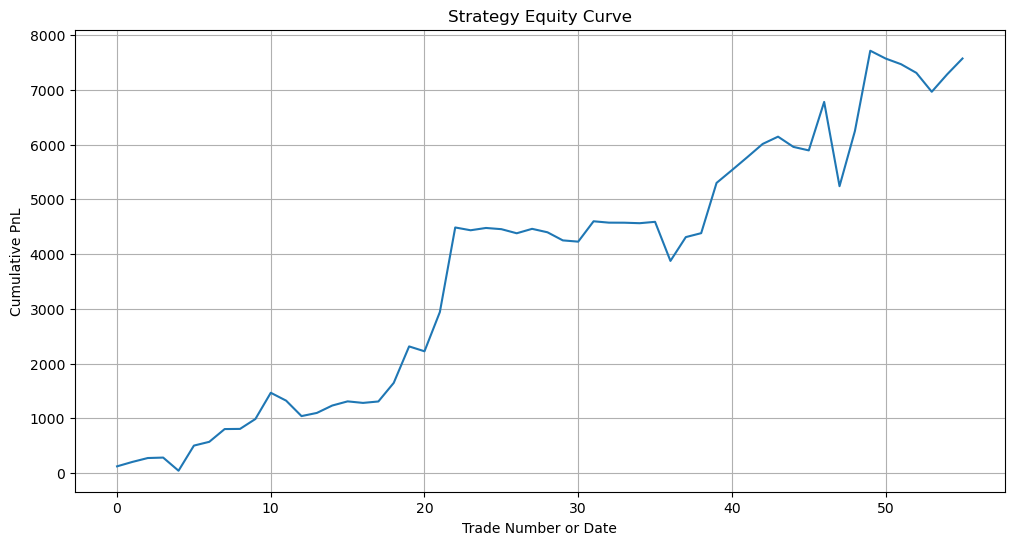

In [111]:
import matplotlib.pyplot as plt

# Assume 'straddle_df' is your DataFrame
EC = trade_df['pnl'].cumsum()

# Plot the EC Series
EC.plot(
    figsize=(12, 6),
    title='Strategy Equity Curve',
    grid=True,
    xlabel='Trade Number or Date',
    ylabel='Cumulative PnL'
)

# Display the plot
plt.show()

In [7]:

def fetch_single_option_all_day(con, ticker, date_str, strike, expiry_str, option_type):
    """
    Fetches a full day of minute-level data for a single, specific option contract.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        date_str (str): The day to query, in 'YYYY-MM-DD' format.
        strike (float): The specific strike price.
        expiry_str (str): The expiry date to filter for, in 'YYYY-MM-DD' format.
        option_type (int): The type of option to fetch (1 for Calls, 0 for Puts).

    Returns:
        pd.DataFrame: A DataFrame containing the minute-by-minute data for the
                      specified contract, or an empty DataFrame if not found.
    """
    option_name = "Call" if option_type == 1 else "Put"
    print(f"Fetching {date_str} data for {ticker} {strike}-strike {option_name} expiring {expiry_str}...")
    
    try:
        # This optimized query selects only the required columns
        query = f"""
            SELECT 
                ts, strike, expiry, dte, optionType, volume, oi,
                bidPrice, askPrice, bidIv, askIv, iv, stockPrice, ticker
            FROM read_parquet('s3://duckdata/ORATS/Options/ticker={ticker}/day={date_str}/*.parquet')
            WHERE 
                strike = {strike} AND
                expiry = '{expiry_str}' AND
                optionType = {option_type}
            ORDER BY
                ts;
            """
        
        strike_df = con.execute(query).df()
        
        if strike_df.empty:
            print("INFO: No data found for this specific contract.")
        strike_df['ts'] = pd.to_datetime(strike_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        strike_df.set_index('ts' , inplace=True)
        return strike_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame() # Return an empty DataFrame on error


In [ ]:
# Get full day data for PUT option

date1 = pd.to_datetime(datetime(2024, 1, 2, 15, 45))
date_str = date1.strftime('%Y-%m-%d')

put_all_day_df = fetch_single_option_all_day(
    con=con,
    ticker='SPY',
    date_str=date_str,
    strike=474,
    expiry_str=date_str,  # Same day expiry
    option_type=-1  # For Puts
)

print(f"Put data shape: {put_all_day_df.shape}")

In [ ]:
put_all_day_df.iloc[-10:]

In [ ]:
check_available_strikes(con, 'SPY', '2024-01-02', '2024-01-02')

In [100]:
import pandas as pd
import pandas_market_calendars as mcal

def fetch_option_data_for_n_days(con, ticker, end_date_str, n_days, strike, expiry_str, option_type):
    """
    Fetches a range of minute-level data for a single option contract
    for a specified number of business days ending on a given date.

    Args:
        con: The DuckDB connection object.
        ticker (str): The stock ticker (e.g., 'SPY').
        end_date_str (str): The last day to query, in 'YYYY-MM-DD' format.
        n_days (int): The number of business days of data to fetch.
        strike (float): The specific strike price.
        expiry_str (str): The expiry date to filter for, in 'YYYY-MM-DD' format.
        option_type (int): The type of option to fetch (1 for Calls, 0 for Puts).

    Returns:
        pd.DataFrame: A DataFrame containing the minute-by-minute data.
    """
    option_name = "Call" if option_type == 1 else "Put"
    print(f"Fetching last {n_days} b-days of data ending on {end_date_str} for {ticker} {strike} {option_name} expiring {expiry_str}...")
    
    try:
        # --- Business Day Calculation Logic ---
        # 1. Get the market calendar
        nyse = mcal.get_calendar('NYSE')
        
        # 2. To be safe, find a start date far enough in the past
        #    (n * 2 is a safe buffer for weekends/holidays)
        start_buffer = pd.to_datetime(end_date_str) - pd.Timedelta(days=n_days * 2)
        
        # 3. Generate a schedule of valid trading days
        schedule = nyse.schedule(start_date=start_buffer, end_date=end_date_str)
        
        # 4. Get the last 'n_days' from the schedule and format them
        business_day_list = [d.strftime('%Y-%m-%d') for d in schedule.index[-n_days:]]
        
        # --- Query Logic (remains the same) ---
        path_list = [
            f"'s3://duckdata/ORATS/Options/ticker={ticker}/day={d}/*.parquet'"
            for d in business_day_list
        ]
        
        query = f"""
            SELECT ts, strike, expiry, dte, optionType, bidPrice, askPrice, stockPrice
            FROM read_parquet([{",".join(path_list)}])
            WHERE 
                strike = {strike} AND
                expiry = '{expiry_str}' AND
                optionType = {option_type}
            ORDER BY ts;
        """
        
        multi_day_df = con.execute(query).df()
        
        if multi_day_df.empty:
            print("INFO: No data found for this contract in the specified date range.")
        
        multi_day_df['ts'] = pd.to_datetime(multi_day_df['ts'].dt.tz_localize('UTC').dt.tz_convert('America/New_York').dt.tz_localize(None))
        multi_day_df.set_index('ts' , inplace=True)
        return multi_day_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

# ==============================================================================
# --- Example Usage ---
# ==============================================================================

# Assume 'con' is your active DuckDB connection

# Get data for the 5 business days ending on September 12, 2025
multi_day_df = fetch_option_data_for_n_days(
    con=con,
    ticker='SPY',
    end_date_str='2024-04-12', # The last day of the range
    n_days=5,                  # How many business days to go back
    strike=550.0,
    expiry_str='2024-04-15',
    option_type=1              # 1 for Call
)

if not multi_day_df.empty:
    print("\n--- Found Data for Date Range ---")
    print(multi_day_df)

Fetching last 5 b-days of data ending on 2024-04-12 for SPY 550.0 Call expiring 2024-04-15...

--- Found Data for Date Range ---
                          strike     expiry  dte  optionType   bidPrice  \
ts                                                                        
2024-04-08 09:30:00 550.00000000 2024-04-15    8           1 0.00000000   
2024-04-08 09:31:00 550.00000000 2024-04-15    8           1 0.01000000   
2024-04-08 09:32:00 550.00000000 2024-04-15    8           1 0.01000000   
2024-04-08 09:33:00 550.00000000 2024-04-15    8           1 0.01000000   
2024-04-08 09:34:00 550.00000000 2024-04-15    8           1 0.01000000   
...                          ...        ...  ...         ...        ...   
2024-04-12 15:56:00 550.00000000 2024-04-15    4           1 0.00000000   
2024-04-12 15:57:00 550.00000000 2024-04-15    4           1 0.00000000   
2024-04-12 15:58:00 550.00000000 2024-04-15    4           1 0.00000000   
2024-04-12 15:59:00 550.00000000 2024-04-15   

In [1]:
com_df

NameError: name 'com_df' is not defined